In [1]:
import os
import neptune
import torch
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fastai.vision.all import *
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import matplotlib.cm as cm

In [ ]:
# Testdatensatz laden
DATASET_DIR = "balanced_dataset_split/balanced_dataset_split"
JSON_PATH = "train_test_split_new.json"

with open(JSON_PATH, "r") as f:
    split_data = json.load(f)

df_test = pd.DataFrame(split_data["test"])
df_test["image_path"] = df_test["file_path"].apply(lambda x: os.path.join(DATASET_DIR, x))

# Vokabular für die Labels erstellen
vocab = df_test["label"].unique().tolist()

# DataBlock für Testdaten
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock(vocab=vocab)),
    get_x=ColReader('image_path'),
    get_y=ColReader('label'),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(224),
)
dls = dblock.dataloaders(df_test, bs=64, num_workers=8)
test_dl = dls.test_dl(df_test, with_labels=True)

# Device erkennen 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [4]:
# Evaluate ResNet50 models

# Liste der Modelle
models = [
    "basemodel_googlenet_bs8",
    "basemodel_googlenet_bs16",
    "basemodel_googlenet_bs32",
    "basemodel_googlenet_bs64",
    "basemodel_googlenet_bs128",
]

# Basispfad zu den .pkl-Dateien
base_path = "basemodel_outputs"

# Ergebnisse speichern
results = []

for model_name in models:
    path = f"{base_path}/{model_name}.pkl"
    
    # Modell laden
    learn = load_learner(path)

    # Vorhersagen
    preds, targs = learn.get_preds(dl=test_dl)
    y_pred = torch.argmax(preds, dim=1).numpy()
    y_true = targs.numpy()
    
    # Metriken berechnen
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall
    })

# DataFrame mit Ergebnissen
df_results = pd.DataFrame(results)
print(df_results)


/home/kavo/.conda/envs/Katha/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/kavo/.conda/envs/Katha/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/kavo/.conda/envs/Katha/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/kavo/.conda/envs/Katha/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       Model  Accuracy  F1 Score  Precision    Recall
0    basemodel_googlenet_bs8  0.653943  0.646050   0.716122  0.653943
1   basemodel_googlenet_bs16  0.621798  0.619167   0.691776  0.621798
2   basemodel_googlenet_bs32  0.598192  0.592893   0.670196  0.598192
3   basemodel_googlenet_bs64  0.579106  0.577900   0.658482  0.579106
4  basemodel_googlenet_bs128  0.841286  0.839944   0.841415  0.841286


/home/kavo/.conda/envs/Katha/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/tmp/ipykernel_503155/2257034068.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Blues')


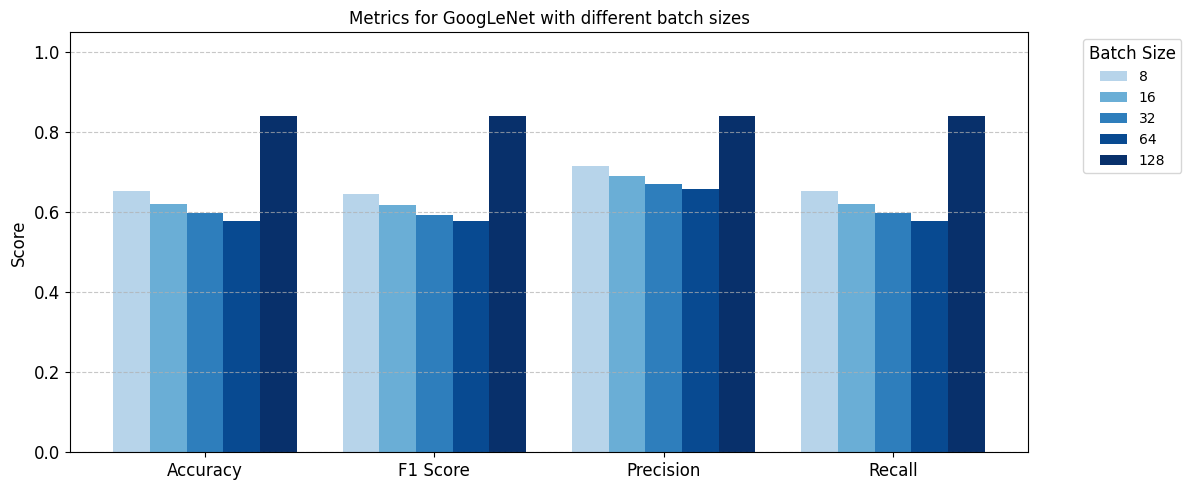

In [ ]:
# Metriken & Modelle
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
n_metrics = len(metrics)
n_models = len(df_results)
group_width = 1.2  
bar_width = group_width / n_models
gap = 0.5  

# X-Positionen der Metrikgruppen
x = np.arange(n_metrics) * (1 + gap)

# Farben aus der "Blues"-Colormap
cmap = cm.get_cmap('Blues')
colors = [cmap(0.3 + 0.8 * i / max(1, n_models - 1)) for i in range(n_models)]

# Mapping der Modellnamen für schönere Beschriftung
label_map = {
    "basemodel_googlenet_bs8": "8",
    "basemodel_googlenet_bs16": "16",
    "basemodel_googlenet_bs32": "32",
    "basemodel_googlenet_bs64": "64",
    "basemodel_googlenet_bs128": "128"
}

# Plot
fig, ax = plt.subplots(figsize=(12, 5))

for i, (idx, row) in enumerate(df_results.iterrows()):
    scores = [row[m] for m in metrics]
    offset = x + i * bar_width - group_width / 2 + bar_width / 2
    label = label_map.get(row['Model'], row['Model'])
    ax.bar(offset, scores, width=bar_width, label=label, color=colors[i])

# Achsen & Styling
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Metrics for GoogLeNet with different batch sizes', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.set_yticks(np.linspace(0, 1.0, 6))
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.set_ylim(0, 1.05)

# Legende
ax.legend(title="Batch Size", title_fontsize=12, fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')

# Gitter und Layout
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("images/googlenet_batchsize_metrics.png", dpi=300)
plt.show()

In [6]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92        88
           1       0.81      0.80      0.80       100
           2       0.71      0.69      0.70       100
           3       0.93      0.87      0.90        15
           4       1.00      0.71      0.83         7
           5       0.92      0.84      0.88        55
           6       0.85      0.79      0.81        14
           7       0.92      0.95      0.93        80
           8       1.00      0.80      0.89         5
           9       0.75      0.76      0.76       100
          10       0.74      0.87      0.80        99
          11       0.40      0.29      0.33         7
          12       0.92      0.84      0.88       100
          13       0.75      0.86      0.80         7
          14       0.90      0.88      0.89       100
          15       0.74      0.80      0.77       100
          16       0.82      0.80      0.81        82
          17       0.70    

/home/kavo/.conda/envs/Katha/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kavo/.conda/envs/Katha/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kavo/.conda/envs/Katha/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [4]:
# Evaluation Tuning with GoogLeNet

# Liste der Modelle
models = [
    "basemodel_googlenet_bs128",
    "googlenet_bs128+aug",
    "googlenet_bs128+aug+iNat"
]

# Basispfad zu den .pkl-Dateien
base_path = "basemodel_outputs"


# Ergebnisse speichern
results = []

for model_name in models:
    path = f"{base_path}/{model_name}.pkl"
    
    # Modell laden
    learn = load_learner(path)

    # Vorhersagen
    preds, targs = learn.get_preds(dl=test_dl)
    y_pred = torch.argmax(preds, dim=1).numpy()
    y_true = targs.numpy()
    
    # Metriken berechnen
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall
    })

# DataFrame mit Ergebnissen
df_results = pd.DataFrame(results)
print(df_results)


/home/kavo/.conda/envs/Katha/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       Model  Accuracy  F1 Score  Precision    Recall
0  basemodel_googlenet_bs128  0.841286  0.839944   0.841415  0.841286
1        googlenet_bs128+aug  0.850829  0.851074   0.854414  0.850829
2   googlenet_bs128+aug+iNat  0.849824  0.848861   0.850982  0.849824


/tmp/ipykernel_1744594/331390960.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Blues')


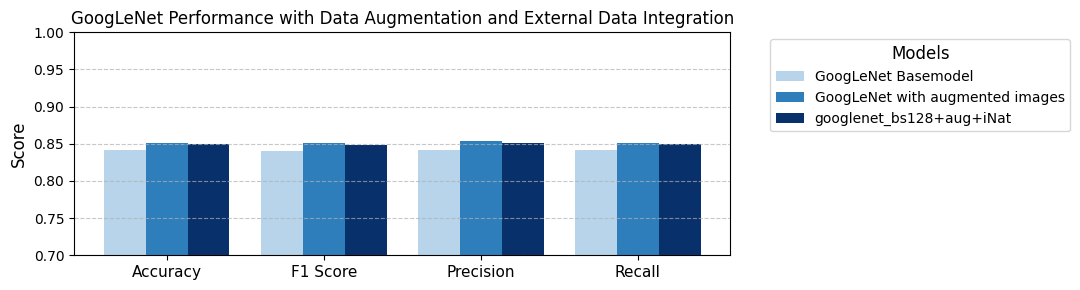

In [ ]:
# Metriken & Modelle
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
n_metrics = len(metrics)
n_models = len(df_results)
group_width = 1.2 
bar_width = group_width / n_models
gap = 0.5  

# X-Positionen der Metrikgruppen
x = np.arange(n_metrics) * (1 + gap)

# Farben aus der "Blues"-Colormap
cmap = cm.get_cmap('Blues')
colors = [cmap(0.3 + 0.8 * i / max(1, n_models - 1)) for i in range(n_models)]

# Mapping der Modellnamen für schönere Beschriftung
label_map = {
    "basemodel_googlenet_bs128": "GoogLeNet Basemodel",
    "googlenet_bs128+aug": "GoogLeNet with augmented images",
    "googlenet_bs128+augm+iNat": "GoogLeNet with augmented & scraped images"
}

# Plot
fig, ax = plt.subplots(figsize=(11, 3))

for i, (idx, row) in enumerate(df_results.iterrows()):
    scores = [row[m] for m in metrics]
    offset = x + i * bar_width - group_width / 2 + bar_width / 2
    label = label_map.get(row['Model'], row['Model'])  # Fallback auf Originalname
    ax.bar(offset, scores, width=bar_width, label=label, color=colors[i])

# Achsen & Styling
ax.set_ylabel('Score', fontsize=12)
ax.set_title('GoogLeNet Performance with Data Augmentation and External Data Integration')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.set_ylim(0.7, 1.0)
ax.legend(title="Models", title_fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("images/GoogLeNet_tuning_metrics.png", dpi=300)
plt.show()